In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
import optuna

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import sys
sys.path.append('../src')
from EvaluationFunction import evaluate_model
from PreprocessingFunction import build_preprocessor
from ValidationCross import cross_val_results


from collections import Counter

import joblib

RANDOM_STATE = 42

---
Load DataSet
---

In [2]:
# Load preprocessed data
df_cleaned = pd.read_csv("../data/preprocessed_data.csv")

In [3]:
# Split features and target variable
X = df_cleaned.drop('Exited', axis=1)
y = df_cleaned['Exited']

---
Preprocessing
---

In [4]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y,random_state=42)

In [5]:
preprocessor = build_preprocessor(X_train)
ratio = Counter(y_train)[0] / Counter(y_train)[1]

---
Optuna
---

[I 2026-01-03 17:30:40,503] A new study created in memory with name: no-name-14fde750-07fa-41fd-ad55-1b0bfbdcbaea
[I 2026-01-03 17:30:41,374] Trial 0 finished with value: 0.8047693503725508 and parameters: {'n_estimators': 419, 'max_depth': 3, 'learning_rate': 0.19677852910221072, 'subsample': 0.8541187158195888}. Best is trial 0 with value: 0.8047693503725508.
[I 2026-01-03 17:30:43,462] Trial 1 finished with value: 0.8398887151579739 and parameters: {'n_estimators': 738, 'max_depth': 4, 'learning_rate': 0.017309777612115933, 'subsample': 0.8827796332342019}. Best is trial 1 with value: 0.8398887151579739.
[I 2026-01-03 17:30:47,538] Trial 2 finished with value: 0.7077829508826793 and parameters: {'n_estimators': 585, 'max_depth': 8, 'learning_rate': 0.09290664383031756, 'subsample': 0.7506773864497224}. Best is trial 1 with value: 0.8398887151579739.
[I 2026-01-03 17:31:01,176] Trial 3 finished with value: 0.7458241979018352 and parameters: {'n_estimators': 774, 'max_depth': 10, 'lea


--- ÉVALUATION OPTUNA ---
Accuracy: 0.8953333333333333
Precision: 0.8114035087719298
Recall: 0.6187290969899666
F1-score: 0.7020872865275142
AUC: 0.9333178315729088

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2402
           1       0.81      0.62      0.70       598

    accuracy                           0.90      3000
   macro avg       0.86      0.79      0.82      3000
weighted avg       0.89      0.90      0.89      3000



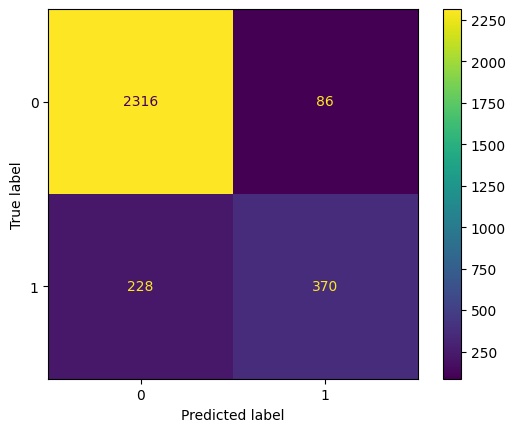

In [15]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "scale_pos_weight": ratio,
        "eval_metric": "logloss",
        "random_state": 42
    }
    model = XGBClassifier(**params)
    pipe = Pipeline([("preprocessor", preprocessor), ("classifier", model)])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(pipe, X_train, y_train, scoring="recall", cv=cv, n_jobs=-1).mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_opt_xgb = XGBClassifier(**study.best_params, random_state=42)
optuna_pipe = Pipeline([("preprocessor", preprocessor), ("classifier", best_opt_xgb)])
optuna_pipe.fit(X_train, y_train)

print("\n--- ÉVALUATION OPTUNA ---")
evaluate_model(y_test, optuna_pipe.predict(X_test), optuna_pipe.predict_proba(X_test)[:, 1])


---
GridSearchCV
---


--- ÉVALUATION GRIDSEARCH ---
Accuracy: 0.89
Precision: 0.768
Recall: 0.6421404682274248
F1-score: 0.6994535519125683
AUC: 0.9311290201309389

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2402
           1       0.77      0.64      0.70       598

    accuracy                           0.89      3000
   macro avg       0.84      0.80      0.82      3000
weighted avg       0.89      0.89      0.89      3000



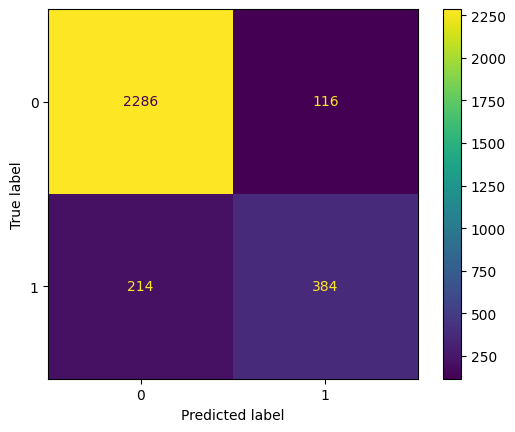

In [12]:
param_grid = {
    "classifier__n_estimators": [study.best_params["n_estimators"] - 50, study.best_params["n_estimators"] + 50],
    "classifier__max_depth": [study.best_params["max_depth"] - 1, study.best_params["max_depth"] + 1]
}

grid = GridSearchCV(optuna_pipe, param_grid, scoring="recall", cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("\n--- ÉVALUATION GRIDSEARCH ---")
evaluate_model(y_test, grid.predict(X_test), grid.predict_proba(X_test)[:, 1])

In [16]:
print("=== Cross Validation: Grid xgbBoost ===")
cross_val_results(grid, X_train, y_train)
print("=== Cross Validation: Optuna xgbBoost ===")
cross_val_results(optuna_pipe, X_train, y_train)

=== Cross Validation: Grid xgbBoost ===
----- Cross Validation Scores -----
accuracy: 0.8984 ± 0.0015
precision: 0.7828 ± 0.0093
recall: 0.6789 ± 0.0058
f1: 0.7271 ± 0.0032
roc_auc: 0.9336 ± 0.0041


=== Cross Validation: Optuna xgbBoost ===
----- Cross Validation Scores -----
accuracy: 0.9012 ± 0.0028
precision: 0.8022 ± 0.0094
recall: 0.6693 ± 0.0089
f1: 0.7297 ± 0.0076
roc_auc: 0.9362 ± 0.0035




---
Class Churn Imbalance 
---


>>> ANALYSE : Sans Équilibre
Recall Score: 0.6421
Accuracy: 0.89
Precision: 0.768
Recall: 0.6421404682274248
F1-score: 0.6994535519125683
AUC: 0.9311290201309389

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2402
           1       0.77      0.64      0.70       598

    accuracy                           0.89      3000
   macro avg       0.84      0.80      0.82      3000
weighted avg       0.89      0.89      0.89      3000



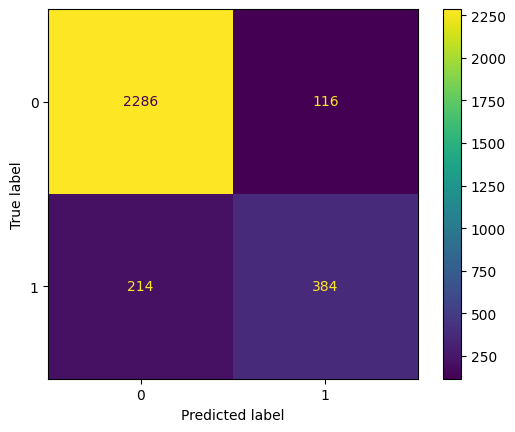


>>> ANALYSE : Weight Only
Recall Score: 0.8161
Accuracy: 0.8726666666666667
Precision: 0.6421052631578947
Recall: 0.8160535117056856
F1-score: 0.7187039764359352
AUC: 0.9306865933906805

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2402
           1       0.64      0.82      0.72       598

    accuracy                           0.87      3000
   macro avg       0.80      0.85      0.82      3000
weighted avg       0.89      0.87      0.88      3000



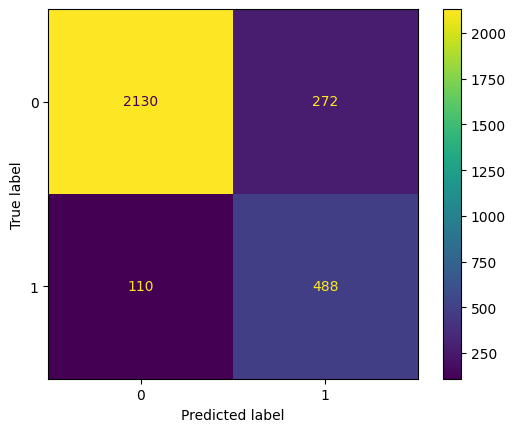


>>> ANALYSE : SMOTE Only
Recall Score: 0.7291
Accuracy: 0.8906666666666667
Precision: 0.7242524916943521
Recall: 0.7290969899665551
F1-score: 0.7266666666666667
AUC: 0.9297053180320748

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2402
           1       0.72      0.73      0.73       598

    accuracy                           0.89      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.89      0.89      0.89      3000



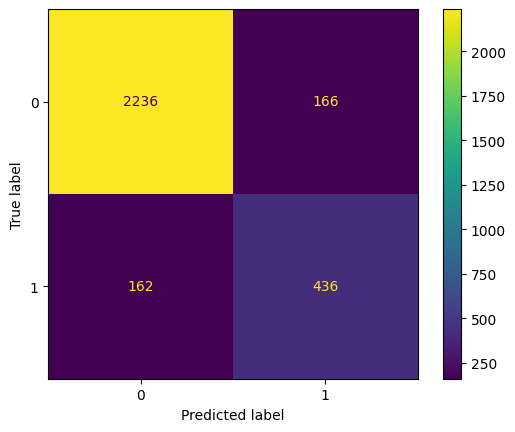


>>> ANALYSE : SMOTE + Weight
Recall Score: 0.8746
Accuracy: 0.842
Precision: 0.5672451193058569
Recall: 0.8745819397993311
F1-score: 0.6881578947368421
AUC: 0.92886571669651

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      2402
           1       0.57      0.87      0.69       598

    accuracy                           0.84      3000
   macro avg       0.77      0.85      0.79      3000
weighted avg       0.88      0.84      0.85      3000



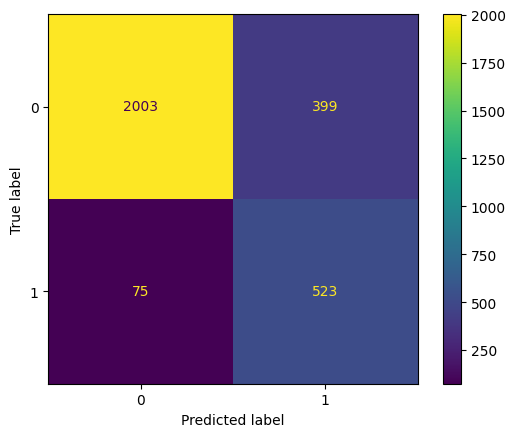

In [19]:
from sklearn.metrics import recall_score

# 1. Calcul du Recall au lieu de l'AUC
# Note : On utilise .predict() car le recall se base sur les classes prédites (0 ou 1)
recall_opt = recall_score(y_test, optuna_pipe.predict(X_test))
recall_gs = recall_score(y_test, grid.predict(X_test))

# 2. Sélection des meilleurs paramètres basée sur le Recall
best_params_moteur = grid.best_estimator_.named_steps['classifier'].get_params() if recall_gs >= recall_opt else best_opt_xgb.get_params()
best_params_moteur = {k: v for k, v in best_params_moteur.items() if k not in ['scale_pos_weight']}

strategies = {
    "Sans Équilibre": Pipeline([("preprocessor", preprocessor), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=1))]),
    "Weight Only": Pipeline([("preprocessor", preprocessor), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=ratio))]),
    "SMOTE Only": ImbPipeline([("preprocessor", preprocessor), ("smote", SMOTE(random_state=42)), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=1))]),
    "SMOTE + Weight": ImbPipeline([("preprocessor", preprocessor), ("smote", SMOTE(random_state=42)), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=ratio))])
}

# 3. Évaluation finale basée sur le Recall
final_recall = {}
for name, pipe in strategies.items():
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)
    
    # Stockage du recall
    final_recall[name] = recall_score(y_test, y_pred)
    
    print(f"\n>>> ANALYSE : {name}")
    print(f"Recall Score: {final_recall[name]:.4f}")
    evaluate_model(y_test, y_pred, y_prob)

---
Selection the best model
---

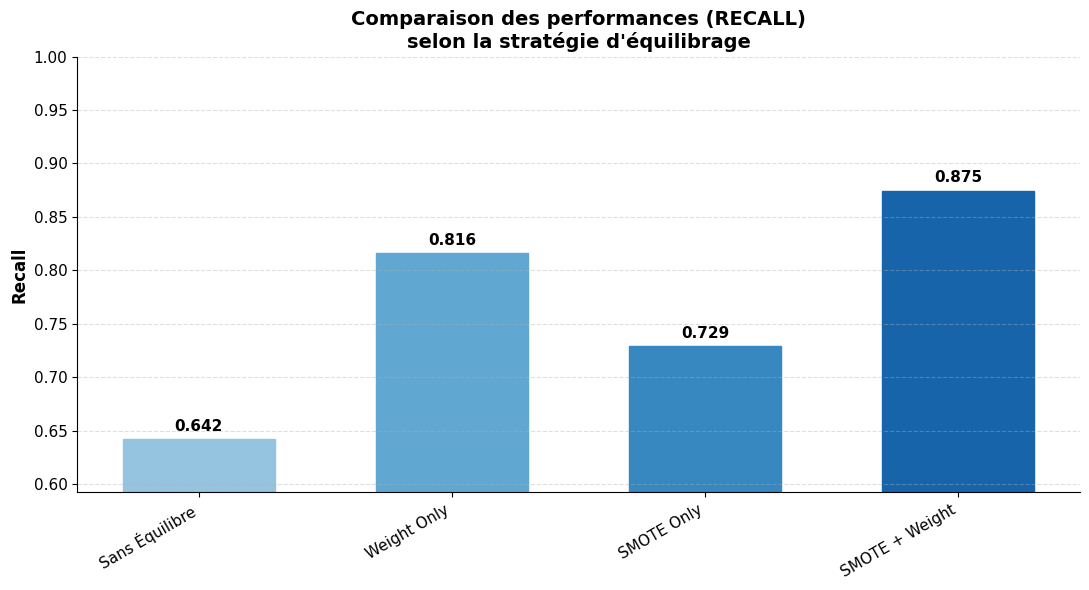

In [21]:
# --- DATA ---
labels = list(final_recall.keys())
values = list(final_recall.values())

# --- FIGURE ---
plt.figure(figsize=(11, 6))

bars = plt.bar(
    labels,
    values,
    width=0.6,
    edgecolor='black',
    linewidth=1
)

# --- COULEURS (gradient propre) ---
colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

# --- ANNOTATIONS (AUC sur les barres) ---
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.005,
        f"{height:.3f}",
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

# --- AXES & TITRES ---
plt.ylim(min(values) - 0.05, 1.0)
plt.ylabel("Recall", fontsize=12, fontweight='bold')
plt.title(
    "Comparaison des performances (RECALL)\nselon la stratégie d'équilibrage",
    fontsize=14,
    fontweight='bold'
)

# --- STYLE PRO ---
plt.xticks(rotation=30, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Suppression des bordures inutiles
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

In [23]:
best_key = max(final_recall, key=final_recall.get)
joblib.dump(strategies[best_key], '../models/best_model.pkl')

['../models/best_model.pkl']